# Experiment 02

### Training on Google Collab 

In [17]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

### Training on Local Machine

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/experiments/experiment_02


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


### 1. Dependencies


In [4]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [5]:
# Local Dependencies
from experiments.experiment_02.environment import SensorEnvironment

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Global Dependencies
from src.data_provider import DataProvider
from src.agent import Agent
from src.custom_types import Behavior
from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, \
    evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior, get_pretrained_ae, pretrain_ae_model

### 2. Hyperparameters

In [7]:
# Hyperparameter
GAMMA = 0.1
BATCH_SIZE = 100
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
EPSILON_START = 1.0
EPSILON_DEC = 1e-4
EPSILON_END = 0.01
TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
N_EPISODES = 10000
LOG_FREQ = 100
DIMS = 20
PI = 3
SAMPLES = 10

### 3. Training

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
size train: (5375, 46), size valid: (1344, 46)
---Training AE---
AE threshold: 0.4145037497588934
save model to: experiments/experiment_02/trained_models/ae_model_pi3.pth
ae_interpreter threshold: 0.4145037497588934
\begin{tabular}{ll}
\hline
 Behavior           & Accuracy   \\
\hline
 normal             & 84.86\%     \\
 ransomware\_poc     & 100.00\%    \\
 bdvl               & 100.00\%    \\
 beurk              & 12.16\%     \\
 the\_tick           & 31.56\%     \\
 backdoor\_jakoritar & 11.22\%     \\
 data\_leak\_1        & 95.40\%     \\
 data\_leak\_2        & 100.00\%    \\
\hline
\end{tabular}
episode  0 | episode_return 1.00 | average episode_return 1.00 | epsilon 1.00
episode  1 | episode_return -0.33 | average episode_return 0.33 | epsilon 1.00
episode  2 | episode_return 1.00 | average episode_return 0.56 | epsilon 1.00
episode  3 | episode_return -0.33 | average episode_return 0.33 | epsil

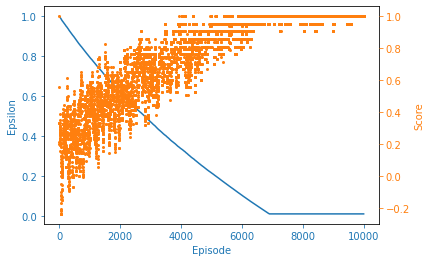

In [8]:
experiment_base_dir = "experiments/experiment_02"

seed_random()
start = time()

# read in all preprocessed data for a simulated, supervised environment to sample from
# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI)
train_data, test_data, scaler = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)
train_data[b] = normal_data[:int(l * s)]  # use fixed number of samples for Reinforcement Agent training
# COMMENT/UNCOMMENT BELOW for pretraining of autoencoder
ae_path = f"{experiment_base_dir}/trained_models/ae_model_pi3.pth"
ae_data = normal_data[int(l * s):]  # use remaining samples for autoencoder
train_ae_x, valid_ae_x = pretrain_ae_model(ae_data=ae_data, path=ae_path, split=0.8, lr=1e-4, momentum=0.9,
                                           num_epochs=100, num_std=2.5)
dims = len(train_ae_x[0, :])
# AE evaluation of pretrained model
ae_interpreter = get_pretrained_ae(path=ae_path, dims=dims)
# AE can directly be tested on the data that will be used for RL: pass train_data to testing
evaluate_ae_on_no_mtd_behavior(ae_interpreter=ae_interpreter, test_data=train_data)

# Reinforcement Learning
env = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)

agent = Agent(input_dims=env.observation_space_size, n_actions=len(env.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END)

# initialize memory replay buffer (randomly)
SimulationEngine.init_replay_memory(agent=agent, env=env, min_size=MIN_REPLAY_SIZE)

# main training
episode_returns, eps_history = SimulationEngine.learn_agent_offline(agent=agent, env=env, num_episodes=N_EPISODES,
                                                                    t_update_freq=TARGET_UPDATE_FREQ)

end = time()
print("Total training time: ", end - start)

num = 0
agent.save_agent_state(num, experiment_base_dir)

x = [i + 1 for i in range(N_EPISODES)]
filename = f"{experiment_base_dir}/mtd_agent_p2_{SAMPLES}_sample.pdf"
plot_learning(x, episode_returns, eps_history, filename)

# check predictions with dqn from trained and stored agent
pretrained_agent = get_pretrained_agent(path=f"{experiment_base_dir}/trained_models/agent_{num}.pth",
                                        input_dims=env.observation_space_size, n_actions=len(env.actions),
                                        buffer_size=BUFFER_SIZE)

evaluate_agent(pretrained_agent, test_data=test_data)

# print("evaluate p2 agent on 'real' decision and afterstate data:")
# dtrain, dtest, atrain, atest = DataProvider.get_reduced_dimensions_with_pca_ds_as(dims,
#                                                                                   dir="offline_prototype_2_raw_behaviors/")
# evaluate_agent(agent=pretrained_agent, test_data=dtest)
# evaluate_agent_on_afterstates(agent=pretrained_agent, test_data=atest)

